In [1]:
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import librosa
import librosa.display
import matplotlib.pyplot as plot
import IPython.display as ipd
import pylab
import pandas as pd
import numpy as np


Using TensorFlow backend.


In [3]:

filename = "./data/tracks/unmastered/pianosolo_unmastered_001.wav"
filename_mastered = "./data/tracks/mastered/pianosolo_mastered_001_var1.wav"
y, sr = librosa.load(filename)
ym, srm = librosa.load(filename_mastered)
ym.shape

(668192,)

In [19]:
# Compute MFCC features from the raw signal
mfccSource = librosa.feature.melspectrogram(y=y, sr=sr).T
mfccTarget = librosa.feature.melspectrogram(y=ym, sr=srm).T

mfccSource.shape




(1306, 128)

In [20]:
unmasteredDf = pd.DataFrame(data=mfccSource, index=np.array(range(1,1307)), columns=np.array(range(1,129)))
masteredDf = pd.DataFrame(data=mfccTarget, index=np.array(range(1,1307)), columns=np.array(range(1,129)))

In [21]:
from keras.layers import LSTM

<Figure size 864x288 with 0 Axes>

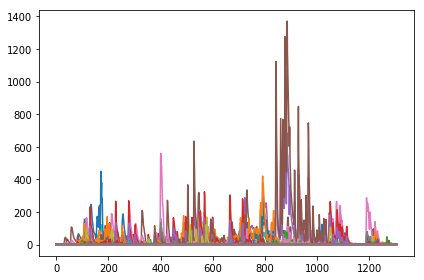

In [34]:
plot.figure(figsize=(12, 4))
unmasteredDf.plot() 
plot.legend().remove()
plot.tight_layout()

<Figure size 864x288 with 0 Axes>

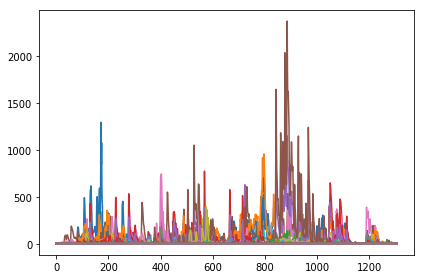

In [23]:
plot.figure(figsize=(12, 4))
masteredDf.plot() 
plot.legend().remove()
plot.tight_layout()

In [36]:
x_train = unmasteredDf.loc[:1200,]
x_test = unmasteredDf.loc[1200:,]
y_train = masteredDf.loc[:1200,]
y_test = masteredDf.loc[1200:,]

In [37]:
from sklearn.preprocessing import MinMaxScaler

In [38]:
sc = MinMaxScaler()
x_train_sc = sc.fit_transform(x_train)
x_test_sc = sc.transform(x_test)
y_train_sc = sc.fit_transform(y_train)
y_test_sc = sc.transform(y_test)

In [39]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

In [40]:
K.clear_session()
model = Sequential()
model.add(Dense(128, input_dim=128, activation='relu'))
model.add(Dense(128))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
Total params: 33,024
Trainable params: 33,024
Non-trainable params: 0
_________________________________________________________________


In [41]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [42]:
model.fit(x_train, y_train, epochs=200, batch_size=2, verbose=1, callbacks=[early_stop])

Epoch 1/200


   2/1200 [..............................] - ETA: 3:45 - loss: 2018.9679

  16/1200 [..............................] - ETA: 31s - loss: 1723.7891 

  30/1200 [..............................] - ETA: 19s - loss: 2971.1417

  46/1200 [>.............................] - ETA: 13s - loss: 2302.5481

  60/1200 [>.............................] - ETA: 11s - loss: 2022.5912

  72/1200 [>.............................] - ETA: 10s - loss: 1789.4193

  88/1200 [=>............................] - ETA: 8s - loss: 1649.7371 

 104/1200 [=>............................] - ETA: 8s - loss: 1505.5911

 126/1200 [==>...........................] - ETA: 6s - loss: 1492.0807

 148/1200 [==>...........................] - ETA: 6s - loss: 1420.5577

 170/1200 [===>..........................] - ETA: 5s - loss: 1513.2717

 190/1200 [===>..........................] - ETA: 5s - loss: 1425.5929

 210/1200 [====>.........................] - ETA: 4s - loss: 1366.3065

 224/1200 [====>.........................] - ETA: 4s - loss: 1307.8301

 244/1200 [=====>........................] - ETA: 4s - loss: 1362.5893

 262/1200 [=====>........................] - ETA: 4s - loss: 1334.2437

 282/1200 [======>.......................] - ETA: 4s - loss: 1284.6384

 302/1200 [======>.......................] - ETA: 3s - loss: 1223.7096

 320/1200 [=======>......................] - ETA: 3s - loss: 1205.7107

 340/1200 [=======>......................] - ETA: 3s - loss: 1156.2133

 358/1200 [=======>......................] - ETA: 3s - loss: 1112.6160

 378/1200 [========>.....................] - ETA: 3s - loss: 1083.2211

 394/1200 [========>.....................] - ETA: 3s - loss: 1047.3815

 414/1200 [=========>....................] - ETA: 3s - loss: 1008.9884

 434/1200 [=========>....................] - ETA: 2s - loss: 1015.8499

 454/1200 [==========>...................] - ETA: 2s - loss: 994.9409 

 472/1200 [==========>...................] - ETA: 2s - loss: 974.4827

 492/1200 [===========>..................] - ETA: 2s - loss: 960.5015

 512/1200 [===========>..................] - ETA: 2s - loss: 939.4853

 532/1200 [============>.................] - ETA: 2s - loss: 933.1817

 552/1200 [============>.................] - ETA: 2s - loss: 915.8091

 572/1200 [=============>................] - ETA: 2s - loss: 899.8169

 592/1200 [=============>................] - ETA: 2s - loss: 883.3091

 608/1200 [==============>...............] - ETA: 2s - loss: 868.2845

 626/1200 [==============>...............] - ETA: 2s - loss: 851.4308

 646/1200 [===============>..............] - ETA: 1s - loss: 831.2703

 666/1200 [===============>..............] - ETA: 1s - loss: 811.6215

 686/1200 [================>.............] - ETA: 1s - loss: 795.5209

 704/1200 [================>.............] - ETA: 1s - loss: 786.0870

 724/1200 [=================>............] - ETA: 1s - loss: 770.0386

 742/1200 [=================>............] - ETA: 1s - loss: 767.2628

 760/1200 [==================>...........] - ETA: 1s - loss: 754.2822

 778/1200 [==================>...........] - ETA: 1s - loss: 745.5470

 796/1200 [==================>...........] - ETA: 1s - loss: 736.9492

 814/1200 [===================>..........] - ETA: 1s - loss: 726.8826

 832/1200 [===================>..........] - ETA: 1s - loss: 714.5696

 852/1200 [====================>.........] - ETA: 1s - loss: 707.8510

 872/1200 [====================>.........] - ETA: 1s - loss: 697.2606

 892/1200 [=====================>........] - ETA: 1s - loss: 688.4421

 912/1200 [=====================>........] - ETA: 0s - loss: 677.4958

 932/1200 [======================>.......] - ETA: 0s - loss: 674.5493

 952/1200 [======================>.......] - ETA: 0s - loss: 662.4532

 972/1200 [=======================>......] - ETA: 0s - loss: 652.9217

 988/1200 [=======================>......] - ETA: 0s - loss: 645.3382

1010/1200 [========================>.....] - ETA: 0s - loss: 632.7042

1028/1200 [========================>.....] - ETA: 0s - loss: 624.9720

1048/1200 [=========================>....] - ETA: 0s - loss: 616.2198

1066/1200 [=========================>....] - ETA: 0s - loss: 607.5343

1086/1200 [==========================>...] - ETA: 0s - loss: 601.6225

1104/1200 [==========================>...] - ETA: 0s - loss: 593.5920

1122/1200 [===========================>..] - ETA: 0s - loss: 586.8420

1142/1200 [===========================>..] - ETA: 0s - loss: 582.3501

1160/1200 [============================>.] - ETA: 0s - loss: 575.5526

1178/1200 [============================>.] - ETA: 0s - loss: 567.9972

1198/1200 [============================>.] - ETA: 0s - loss: 560.1507

1200/1200 [==============================] - 4s 3ms/step - loss: 559.5189


Epoch 2/200
   2/1200 [..............................] - ETA: 3s - loss: 39.9224

  18/1200 [..............................] - ETA: 4s - loss: 89.4254

  40/1200 [>.............................] - ETA: 3s - loss: 231.8304

  58/1200 [>.............................] - ETA: 3s - loss: 186.6208

  74/1200 [>.............................] - ETA: 3s - loss: 210.8151

  94/1200 [=>............................] - ETA: 3s - loss: 193.6446

 114/1200 [=>............................] - ETA: 3s - loss: 187.6649

 134/1200 [==>...........................] - ETA: 3s - loss: 181.0927

 154/1200 [==>...........................] - ETA: 2s - loss: 184.8794

 174/1200 [===>..........................] - ETA: 2s - loss: 178.6358

 196/1200 [===>..........................] - ETA: 2s - loss: 191.3568

 216/1200 [====>.........................] - ETA: 2s - loss: 188.9773

 236/1200 [====>.........................] - ETA: 2s - loss: 180.0918

 254/1200 [=====>........................] - ETA: 2s - loss: 178.6324

 274/1200 [=====>........................] - ETA: 2s - loss: 175.5399

 292/1200 [======>.......................] - ETA: 2s - loss: 168.7653

 312/1200 [======>.......................] - ETA: 2s - loss: 164.8884

 332/1200 [=======>......................] - ETA: 2s - loss: 157.5449

 352/1200 [=======>......................] - ETA: 2s - loss: 166.1106

 370/1200 [========>.....................] - ETA: 2s - loss: 164.4791

 390/1200 [========>.....................] - ETA: 2s - loss: 160.7455

 410/1200 [=========>....................] - ETA: 2s - loss: 155.6129

 430/1200 [=========>....................] - ETA: 2s - loss: 154.3254

 448/1200 [==========>...................] - ETA: 2s - loss: 159.8210

 468/1200 [==========>...................] - ETA: 1s - loss: 159.9230

 488/1200 [===========>..................] - ETA: 1s - loss: 160.0229

 508/1200 [===========>..................] - ETA: 1s - loss: 167.9913

 528/1200 [============>.................] - ETA: 1s - loss: 166.9853

 548/1200 [============>.................] - ETA: 1s - loss: 172.8937

 568/1200 [=============>................] - ETA: 1s - loss: 169.8600

 588/1200 [=============>................] - ETA: 1s - loss: 166.1015

 608/1200 [==============>...............] - ETA: 1s - loss: 167.6360

 626/1200 [==============>...............] - ETA: 1s - loss: 165.2400

 646/1200 [===============>..............] - ETA: 1s - loss: 162.1590

 664/1200 [===============>..............] - ETA: 1s - loss: 160.8010

 684/1200 [================>.............] - ETA: 1s - loss: 158.4801

 704/1200 [================>.............] - ETA: 1s - loss: 155.6977

 724/1200 [=================>............] - ETA: 1s - loss: 156.4796

 744/1200 [=================>............] - ETA: 1s - loss: 154.7213

 764/1200 [==================>...........] - ETA: 1s - loss: 153.8199

 784/1200 [==================>...........] - ETA: 1s - loss: 152.6421

 804/1200 [===================>..........] - ETA: 1s - loss: 154.6275

 824/1200 [===================>..........] - ETA: 1s - loss: 154.5505

 844/1200 [====================>.........] - ETA: 0s - loss: 155.1654

 862/1200 [====================>.........] - ETA: 0s - loss: 154.0450

 882/1200 [=====================>........] - ETA: 0s - loss: 153.7839

 902/1200 [=====================>........] - ETA: 0s - loss: 152.8825

 922/1200 [======================>.......] - ETA: 0s - loss: 152.7032

 940/1200 [======================>.......] - ETA: 0s - loss: 151.3881

 962/1200 [=======================>......] - ETA: 0s - loss: 149.5086

 982/1200 [=======================>......] - ETA: 0s - loss: 149.3905

1004/1200 [========================>.....] - ETA: 0s - loss: 149.2994

1026/1200 [========================>.....] - ETA: 0s - loss: 148.4128

1048/1200 [=========================>....] - ETA: 0s - loss: 147.4223

1070/1200 [=========================>....] - ETA: 0s - loss: 145.7452

1092/1200 [==========================>...] - ETA: 0s - loss: 146.3032

1110/1200 [==========================>...] - ETA: 0s - loss: 147.2449

1132/1200 [===========================>..] - ETA: 0s - loss: 146.1295

1154/1200 [===========================>..] - ETA: 0s - loss: 145.2179

1176/1200 [============================>.] - ETA: 0s - loss: 143.8989

1198/1200 [============================>.] - ETA: 0s - loss: 142.3655

1200/1200 [==============================] - 3s 3ms/step - loss: 142.1282


Epoch 3/200
   2/1200 [..............................] - ETA: 3s - loss: 34.6783

  22/1200 [..............................] - ETA: 3s - loss: 154.1328

  44/1200 [>.............................] - ETA: 2s - loss: 164.8073

  64/1200 [>.............................] - ETA: 2s - loss: 149.8320

  84/1200 [=>............................] - ETA: 2s - loss: 141.4264

 106/1200 [=>............................] - ETA: 2s - loss: 131.0025

 128/1200 [==>...........................] - ETA: 2s - loss: 120.5478

 150/1200 [==>...........................] - ETA: 2s - loss: 126.2232

 172/1200 [===>..........................] - ETA: 2s - loss: 124.3227

 194/1200 [===>..........................] - ETA: 2s - loss: 123.4775

 216/1200 [====>.........................] - ETA: 2s - loss: 130.6990

 238/1200 [====>.........................] - ETA: 2s - loss: 124.8869

 260/1200 [=====>........................] - ETA: 2s - loss: 125.6661

 282/1200 [======>.......................] - ETA: 2s - loss: 123.9556

 304/1200 [======>.......................] - ETA: 2s - loss: 123.0706

 326/1200 [=======>......................] - ETA: 2s - loss: 119.6571

 348/1200 [=======>......................] - ETA: 2s - loss: 120.5661

 370/1200 [========>.....................] - ETA: 2s - loss: 123.4315

 392/1200 [========>.....................] - ETA: 1s - loss: 120.2529

 414/1200 [=========>....................] - ETA: 1s - loss: 120.4451

 436/1200 [=========>....................] - ETA: 1s - loss: 116.2547

 460/1200 [==========>...................] - ETA: 1s - loss: 117.0501

 480/1200 [===========>..................] - ETA: 1s - loss: 114.3386

 502/1200 [===========>..................] - ETA: 1s - loss: 112.0871

 524/1200 [============>.................] - ETA: 1s - loss: 111.2394

 546/1200 [============>.................] - ETA: 1s - loss: 112.2740

 568/1200 [=============>................] - ETA: 1s - loss: 110.8989

 590/1200 [=============>................] - ETA: 1s - loss: 110.6419

 610/1200 [==============>...............] - ETA: 1s - loss: 111.1888

 632/1200 [==============>...............] - ETA: 1s - loss: 109.7343

 652/1200 [===============>..............] - ETA: 1s - loss: 108.2809

 674/1200 [===============>..............] - ETA: 1s - loss: 106.5720

 696/1200 [================>.............] - ETA: 1s - loss: 104.9193

 716/1200 [================>.............] - ETA: 1s - loss: 103.6028

 738/1200 [=================>............] - ETA: 1s - loss: 105.2957

 760/1200 [==================>...........] - ETA: 1s - loss: 105.4046

 782/1200 [==================>...........] - ETA: 1s - loss: 105.3382

 804/1200 [===================>..........] - ETA: 0s - loss: 104.8249

 828/1200 [===================>..........] - ETA: 0s - loss: 103.3449

 848/1200 [====================>.........] - ETA: 0s - loss: 101.9973

 870/1200 [====================>.........] - ETA: 0s - loss: 101.0283

 892/1200 [=====================>........] - ETA: 0s - loss: 100.4054

 914/1200 [=====================>........] - ETA: 0s - loss: 98.9732 

 936/1200 [======================>.......] - ETA: 0s - loss: 99.5989

 958/1200 [======================>.......] - ETA: 0s - loss: 99.6190

 978/1200 [=======================>......] - ETA: 0s - loss: 102.7619

1002/1200 [========================>.....] - ETA: 0s - loss: 102.1628

1022/1200 [========================>.....] - ETA: 0s - loss: 107.3562

1044/1200 [=========================>....] - ETA: 0s - loss: 106.0730

1066/1200 [=========================>....] - ETA: 0s - loss: 107.6633

1088/1200 [==========================>...] - ETA: 0s - loss: 106.4152

1112/1200 [==========================>...] - ETA: 0s - loss: 106.1480

1134/1200 [===========================>..] - ETA: 0s - loss: 105.9743

1156/1200 [===========================>..] - ETA: 0s - loss: 106.5322

1178/1200 [============================>.] - ETA: 0s - loss: 106.1362

1200/1200 [==============================] - 3s 2ms/step - loss: 105.3401


Epoch 4/200
   2/1200 [..............................] - ETA: 3s - loss: 85.5711

  20/1200 [..............................] - ETA: 3s - loss: 60.5148

  42/1200 [>.............................] - ETA: 3s - loss: 60.0772

  62/1200 [>.............................] - ETA: 2s - loss: 88.1001

  84/1200 [=>............................] - ETA: 2s - loss: 104.8249

 104/1200 [=>............................] - ETA: 2s - loss: 99.7689 

 126/1200 [==>...........................] - ETA: 2s - loss: 101.8298

 146/1200 [==>...........................] - ETA: 2s - loss: 93.9988 

 168/1200 [===>..........................] - ETA: 2s - loss: 96.4635

 188/1200 [===>..........................] - ETA: 2s - loss: 97.5968

 210/1200 [====>.........................] - ETA: 2s - loss: 92.7729

 232/1200 [====>.........................] - ETA: 2s - loss: 90.0155

 254/1200 [=====>........................] - ETA: 2s - loss: 88.0750

 276/1200 [=====>........................] - ETA: 2s - loss: 89.0466

 298/1200 [======>.......................] - ETA: 2s - loss: 87.8015

 320/1200 [=======>......................] - ETA: 2s - loss: 87.0649

 344/1200 [=======>......................] - ETA: 2s - loss: 85.5824

 366/1200 [========>.....................] - ETA: 2s - loss: 85.0850

 388/1200 [========>.....................] - ETA: 1s - loss: 88.6457

 408/1200 [=========>....................] - ETA: 1s - loss: 92.5157

 430/1200 [=========>....................] - ETA: 1s - loss: 91.9361

 454/1200 [==========>...................] - ETA: 1s - loss: 92.1001

 476/1200 [==========>...................] - ETA: 1s - loss: 91.5855

 498/1200 [===========>..................] - ETA: 1s - loss: 94.2419

 520/1200 [============>.................] - ETA: 1s - loss: 92.3873

 542/1200 [============>.................] - ETA: 1s - loss: 91.5468

 564/1200 [=============>................] - ETA: 1s - loss: 89.5582

 586/1200 [=============>................] - ETA: 1s - loss: 89.4482

 606/1200 [==============>...............] - ETA: 1s - loss: 89.2445

 628/1200 [==============>...............] - ETA: 1s - loss: 88.1852

 650/1200 [===============>..............] - ETA: 1s - loss: 87.7364

 672/1200 [===============>..............] - ETA: 1s - loss: 88.9556

 694/1200 [================>.............] - ETA: 1s - loss: 90.1595

 714/1200 [================>.............] - ETA: 1s - loss: 88.8851

 734/1200 [=================>............] - ETA: 1s - loss: 88.6255

 756/1200 [=================>............] - ETA: 1s - loss: 88.1748

 776/1200 [==================>...........] - ETA: 1s - loss: 87.9351

 798/1200 [==================>...........] - ETA: 0s - loss: 88.3111

 820/1200 [===================>..........] - ETA: 0s - loss: 88.2028

 840/1200 [====================>.........] - ETA: 0s - loss: 87.3689

 862/1200 [====================>.........] - ETA: 0s - loss: 86.4937

 884/1200 [=====================>........] - ETA: 0s - loss: 93.3354

 906/1200 [=====================>........] - ETA: 0s - loss: 100.2821

 928/1200 [======================>.......] - ETA: 0s - loss: 99.1163 

 948/1200 [======================>.......] - ETA: 0s - loss: 99.0346

 968/1200 [=======================>......] - ETA: 0s - loss: 100.3027

 990/1200 [=======================>......] - ETA: 0s - loss: 99.6355 

1012/1200 [========================>.....] - ETA: 0s - loss: 101.7765

1034/1200 [========================>.....] - ETA: 0s - loss: 101.4665

1056/1200 [=========================>....] - ETA: 0s - loss: 102.4519

1078/1200 [=========================>....] - ETA: 0s - loss: 101.1636

1100/1200 [==========================>...] - ETA: 0s - loss: 101.0430

1122/1200 [===========================>..] - ETA: 0s - loss: 100.0766

1144/1200 [===========================>..] - ETA: 0s - loss: 99.3297 

1166/1200 [============================>.] - ETA: 0s - loss: 100.3317

1188/1200 [============================>.] - ETA: 0s - loss: 99.3392 

1200/1200 [==============================] - 3s 2ms/step - loss: 98.7053


Epoch 5/200
   2/1200 [..............................] - ETA: 3s - loss: 40.1173

  22/1200 [..............................] - ETA: 2s - loss: 134.8895

  44/1200 [>.............................] - ETA: 2s - loss: 86.3709 

  66/1200 [>.............................] - ETA: 2s - loss: 78.6965

  88/1200 [=>............................] - ETA: 2s - loss: 89.8117

 108/1200 [=>............................] - ETA: 2s - loss: 86.7320

 132/1200 [==>...........................] - ETA: 2s - loss: 82.0389

 154/1200 [==>...........................] - ETA: 2s - loss: 76.1772

 174/1200 [===>..........................] - ETA: 2s - loss: 79.3691

 194/1200 [===>..........................] - ETA: 2s - loss: 75.8098

 216/1200 [====>.........................] - ETA: 2s - loss: 73.3234

 236/1200 [====>.........................] - ETA: 2s - loss: 73.5207

 260/1200 [=====>........................] - ETA: 2s - loss: 71.6145

 284/1200 [======>.......................] - ETA: 2s - loss: 76.4737

 306/1200 [======>.......................] - ETA: 2s - loss: 77.2090

 328/1200 [=======>......................] - ETA: 2s - loss: 84.4649

 348/1200 [=======>......................] - ETA: 2s - loss: 83.6886

 372/1200 [========>.....................] - ETA: 1s - loss: 87.4706

 394/1200 [========>.....................] - ETA: 1s - loss: 85.5958

 416/1200 [=========>....................] - ETA: 1s - loss: 85.7363

 440/1200 [==========>...................] - ETA: 1s - loss: 85.5914

 462/1200 [==========>...................] - ETA: 1s - loss: 83.9028

 484/1200 [===========>..................] - ETA: 1s - loss: 83.4754

 506/1200 [===========>..................] - ETA: 1s - loss: 83.7281

 528/1200 [============>.................] - ETA: 1s - loss: 82.2879

 552/1200 [============>.................] - ETA: 1s - loss: 81.8617

 574/1200 [=============>................] - ETA: 1s - loss: 80.5630

 596/1200 [=============>................] - ETA: 1s - loss: 80.7556

 618/1200 [==============>...............] - ETA: 1s - loss: 79.3336

 638/1200 [==============>...............] - ETA: 1s - loss: 79.5815

 662/1200 [===============>..............] - ETA: 1s - loss: 80.2880

 684/1200 [================>.............] - ETA: 1s - loss: 79.8363

 706/1200 [================>.............] - ETA: 1s - loss: 82.2651

 728/1200 [=================>............] - ETA: 1s - loss: 86.2029

 750/1200 [=================>............] - ETA: 1s - loss: 87.0022

 772/1200 [==================>...........] - ETA: 1s - loss: 88.7391

 794/1200 [==================>...........] - ETA: 0s - loss: 88.1629

 816/1200 [===================>..........] - ETA: 0s - loss: 88.1863

 840/1200 [====================>.........] - ETA: 0s - loss: 87.6303

 862/1200 [====================>.........] - ETA: 0s - loss: 87.6230

 884/1200 [=====================>........] - ETA: 0s - loss: 86.7842

 904/1200 [=====================>........] - ETA: 0s - loss: 86.8886

 926/1200 [======================>.......] - ETA: 0s - loss: 85.7974

 950/1200 [======================>.......] - ETA: 0s - loss: 85.0885

 972/1200 [=======================>......] - ETA: 0s - loss: 85.6590

 994/1200 [=======================>......] - ETA: 0s - loss: 85.1163

1016/1200 [========================>.....] - ETA: 0s - loss: 86.2923

1038/1200 [========================>.....] - ETA: 0s - loss: 88.0295

1062/1200 [=========================>....] - ETA: 0s - loss: 89.2791

1082/1200 [==========================>...] - ETA: 0s - loss: 91.2022

1104/1200 [==========================>...] - ETA: 0s - loss: 92.1505

1128/1200 [===========================>..] - ETA: 0s - loss: 91.8216

1150/1200 [===========================>..] - ETA: 0s - loss: 91.7277

1170/1200 [============================>.] - ETA: 0s - loss: 91.4148

1190/1200 [============================>.] - ETA: 0s - loss: 90.7316

1200/1200 [==============================] - 3s 2ms/step - loss: 90.6297


Epoch 6/200
   2/1200 [..............................] - ETA: 3s - loss: 9.1620

  22/1200 [..............................] - ETA: 3s - loss: 120.9900

  42/1200 [>.............................] - ETA: 3s - loss: 107.9594

  64/1200 [>.............................] - ETA: 2s - loss: 98.7895 

  86/1200 [=>............................] - ETA: 2s - loss: 90.5063

 108/1200 [=>............................] - ETA: 2s - loss: 86.0044

 128/1200 [==>...........................] - ETA: 2s - loss: 89.3378

 150/1200 [==>...........................] - ETA: 2s - loss: 117.2955

 172/1200 [===>..........................] - ETA: 2s - loss: 110.0898

 192/1200 [===>..........................] - ETA: 2s - loss: 102.8964

 214/1200 [====>.........................] - ETA: 2s - loss: 104.8874

 234/1200 [====>.........................] - ETA: 2s - loss: 101.5407

 254/1200 [=====>........................] - ETA: 2s - loss: 98.4776 

 276/1200 [=====>........................] - ETA: 2s - loss: 105.5894

 300/1200 [======>.......................] - ETA: 2s - loss: 103.6336

 320/1200 [=======>......................] - ETA: 2s - loss: 100.8591

 340/1200 [=======>......................] - ETA: 2s - loss: 100.8031

 362/1200 [========>.....................] - ETA: 2s - loss: 99.5284 

 384/1200 [========>.....................] - ETA: 1s - loss: 98.1527

 406/1200 [=========>....................] - ETA: 1s - loss: 96.3887

 428/1200 [=========>....................] - ETA: 1s - loss: 103.5815

 450/1200 [==========>...................] - ETA: 1s - loss: 101.6585

 472/1200 [==========>...................] - ETA: 1s - loss: 100.5585

 494/1200 [===========>..................] - ETA: 1s - loss: 103.6924

 516/1200 [===========>..................] - ETA: 1s - loss: 102.9593

 538/1200 [============>.................] - ETA: 1s - loss: 105.1753

 560/1200 [=============>................] - ETA: 1s - loss: 106.4357

 580/1200 [=============>................] - ETA: 1s - loss: 103.8037

 602/1200 [==============>...............] - ETA: 1s - loss: 106.1242

 622/1200 [==============>...............] - ETA: 1s - loss: 104.6927

 642/1200 [===============>..............] - ETA: 1s - loss: 102.6997

 666/1200 [===============>..............] - ETA: 1s - loss: 100.7867

 690/1200 [================>.............] - ETA: 1s - loss: 100.1234

 710/1200 [================>.............] - ETA: 1s - loss: 99.7912 

 732/1200 [=================>............] - ETA: 1s - loss: 98.4832

 756/1200 [=================>............] - ETA: 1s - loss: 97.0739

 776/1200 [==================>...........] - ETA: 1s - loss: 96.9434

 796/1200 [==================>...........] - ETA: 0s - loss: 96.7030

 818/1200 [===================>..........] - ETA: 0s - loss: 95.3049

 840/1200 [====================>.........] - ETA: 0s - loss: 96.1513

 862/1200 [====================>.........] - ETA: 0s - loss: 95.0435

 882/1200 [=====================>........] - ETA: 0s - loss: 94.2048

 904/1200 [=====================>........] - ETA: 0s - loss: 93.5675

 926/1200 [======================>.......] - ETA: 0s - loss: 92.1232

 950/1200 [======================>.......] - ETA: 0s - loss: 91.6603

 972/1200 [=======================>......] - ETA: 0s - loss: 91.0199

 990/1200 [=======================>......] - ETA: 0s - loss: 90.7590

1012/1200 [========================>.....] - ETA: 0s - loss: 90.6125

1032/1200 [========================>.....] - ETA: 0s - loss: 89.7461

1054/1200 [=========================>....] - ETA: 0s - loss: 89.3827

1076/1200 [=========================>....] - ETA: 0s - loss: 89.0482

1098/1200 [==========================>...] - ETA: 0s - loss: 88.5307

1120/1200 [===========================>..] - ETA: 0s - loss: 90.5954

1142/1200 [===========================>..] - ETA: 0s - loss: 89.9807

1164/1200 [============================>.] - ETA: 0s - loss: 89.9302

1186/1200 [============================>.] - ETA: 0s - loss: 88.9841

1200/1200 [==============================] - 3s 2ms/step - loss: 88.9255


Epoch 7/200


   2/1200 [..............................] - ETA: 3s - loss: 8.7699

  20/1200 [..............................] - ETA: 3s - loss: 60.4044

  42/1200 [>.............................] - ETA: 2s - loss: 102.6992

  62/1200 [>.............................] - ETA: 2s - loss: 128.1441

  84/1200 [=>............................] - ETA: 2s - loss: 108.0305

 106/1200 [=>............................] - ETA: 2s - loss: 112.5768

 128/1200 [==>...........................] - ETA: 2s - loss: 103.7636

 148/1200 [==>...........................] - ETA: 2s - loss: 100.8560

 170/1200 [===>..........................] - ETA: 2s - loss: 96.8887 

 192/1200 [===>..........................] - ETA: 2s - loss: 99.5838

 214/1200 [====>.........................] - ETA: 2s - loss: 96.2540

 236/1200 [====>.........................] - ETA: 2s - loss: 103.1545

 258/1200 [=====>........................] - ETA: 2s - loss: 99.8795 

 280/1200 [======>.......................] - ETA: 2s - loss: 101.8939

 302/1200 [======>.......................] - ETA: 2s - loss: 103.9622

 322/1200 [=======>......................] - ETA: 2s - loss: 102.2420

 344/1200 [=======>......................] - ETA: 2s - loss: 106.2692

 366/1200 [========>.....................] - ETA: 2s - loss: 104.7903

 388/1200 [========>.....................] - ETA: 1s - loss: 101.6233

 408/1200 [=========>....................] - ETA: 1s - loss: 100.7584

 430/1200 [=========>....................] - ETA: 1s - loss: 100.6601

 450/1200 [==========>...................] - ETA: 1s - loss: 98.7579 

 472/1200 [==========>...................] - ETA: 1s - loss: 97.1742

 494/1200 [===========>..................] - ETA: 1s - loss: 95.7460

 516/1200 [===========>..................] - ETA: 1s - loss: 93.7881

 536/1200 [============>.................] - ETA: 1s - loss: 92.9685

 558/1200 [============>.................] - ETA: 1s - loss: 91.1492

 578/1200 [=============>................] - ETA: 1s - loss: 90.4215

 598/1200 [=============>................] - ETA: 1s - loss: 88.9158

 620/1200 [==============>...............] - ETA: 1s - loss: 87.7973

 642/1200 [===============>..............] - ETA: 1s - loss: 87.3289

 664/1200 [===============>..............] - ETA: 1s - loss: 87.0191

 686/1200 [================>.............] - ETA: 1s - loss: 85.8958

 708/1200 [================>.............] - ETA: 1s - loss: 84.6871

 728/1200 [=================>............] - ETA: 1s - loss: 83.7282

 750/1200 [=================>............] - ETA: 1s - loss: 83.6379

 772/1200 [==================>...........] - ETA: 1s - loss: 84.6296

 794/1200 [==================>...........] - ETA: 0s - loss: 83.3812

 816/1200 [===================>..........] - ETA: 0s - loss: 83.0461

 838/1200 [===================>..........] - ETA: 0s - loss: 82.1446

 858/1200 [====================>.........] - ETA: 0s - loss: 81.3481

 880/1200 [=====================>........] - ETA: 0s - loss: 81.1792

 900/1200 [=====================>........] - ETA: 0s - loss: 80.9716

 922/1200 [======================>.......] - ETA: 0s - loss: 80.4461

 944/1200 [======================>.......] - ETA: 0s - loss: 82.5041

 966/1200 [=======================>......] - ETA: 0s - loss: 81.8200

 988/1200 [=======================>......] - ETA: 0s - loss: 81.5355

1010/1200 [========================>.....] - ETA: 0s - loss: 81.3630

1032/1200 [========================>.....] - ETA: 0s - loss: 84.3970

1054/1200 [=========================>....] - ETA: 0s - loss: 83.7707

1076/1200 [=========================>....] - ETA: 0s - loss: 82.9919

1098/1200 [==========================>...] - ETA: 0s - loss: 83.3327

1120/1200 [===========================>..] - ETA: 0s - loss: 82.5519

1142/1200 [===========================>..] - ETA: 0s - loss: 84.2609

1164/1200 [============================>.] - ETA: 0s - loss: 83.3533

1186/1200 [============================>.] - ETA: 0s - loss: 82.7684

1200/1200 [==============================] - 3s 2ms/step - loss: 84.0239


Epoch 8/200
   2/1200 [..............................] - ETA: 3s - loss: 36.9954

  24/1200 [..............................] - ETA: 2s - loss: 99.8190

  46/1200 [>.............................] - ETA: 2s - loss: 73.5795

  64/1200 [>.............................] - ETA: 2s - loss: 67.7779

  86/1200 [=>............................] - ETA: 2s - loss: 65.3340

 108/1200 [=>............................] - ETA: 2s - loss: 68.6986

 130/1200 [==>...........................] - ETA: 2s - loss: 66.1173

 150/1200 [==>...........................] - ETA: 2s - loss: 86.3721

 172/1200 [===>..........................] - ETA: 2s - loss: 84.0380

 192/1200 [===>..........................] - ETA: 2s - loss: 80.8480

 214/1200 [====>.........................] - ETA: 2s - loss: 87.3032

 234/1200 [====>.........................] - ETA: 2s - loss: 82.8667

 256/1200 [=====>........................] - ETA: 2s - loss: 80.2387

 276/1200 [=====>........................] - ETA: 2s - loss: 78.7932

 296/1200 [======>.......................] - ETA: 2s - loss: 77.1969

 318/1200 [======>.......................] - ETA: 2s - loss: 82.6018

 338/1200 [=======>......................] - ETA: 2s - loss: 86.0407

 362/1200 [========>.....................] - ETA: 2s - loss: 85.3210

 384/1200 [========>.....................] - ETA: 2s - loss: 83.7008

 406/1200 [=========>....................] - ETA: 1s - loss: 84.2972

 422/1200 [=========>....................] - ETA: 1s - loss: 87.4659

 444/1200 [==========>...................] - ETA: 1s - loss: 85.3992

 464/1200 [==========>...................] - ETA: 1s - loss: 86.2808

 484/1200 [===========>..................] - ETA: 1s - loss: 86.4311

 504/1200 [===========>..................] - ETA: 1s - loss: 84.4118

 526/1200 [============>.................] - ETA: 1s - loss: 83.4074

 546/1200 [============>.................] - ETA: 1s - loss: 87.3448

 568/1200 [=============>................] - ETA: 1s - loss: 88.4210

 588/1200 [=============>................] - ETA: 1s - loss: 86.7146

 608/1200 [==============>...............] - ETA: 1s - loss: 86.0857

 628/1200 [==============>...............] - ETA: 1s - loss: 87.3373

 648/1200 [===============>..............] - ETA: 1s - loss: 86.5361

 670/1200 [===============>..............] - ETA: 1s - loss: 84.5174

 690/1200 [================>.............] - ETA: 1s - loss: 83.7317

 710/1200 [================>.............] - ETA: 1s - loss: 83.3676

 730/1200 [=================>............] - ETA: 1s - loss: 82.3586

 750/1200 [=================>............] - ETA: 1s - loss: 82.5290

 768/1200 [==================>...........] - ETA: 1s - loss: 82.7944

 788/1200 [==================>...........] - ETA: 1s - loss: 82.8921

 806/1200 [===================>..........] - ETA: 1s - loss: 82.0281

 826/1200 [===================>..........] - ETA: 0s - loss: 82.0994

 844/1200 [====================>.........] - ETA: 0s - loss: 81.5926

 864/1200 [====================>.........] - ETA: 0s - loss: 80.4278

 882/1200 [=====================>........] - ETA: 0s - loss: 82.9414

 902/1200 [=====================>........] - ETA: 0s - loss: 81.9788

 922/1200 [======================>.......] - ETA: 0s - loss: 82.7975

 942/1200 [======================>.......] - ETA: 0s - loss: 83.0611

 962/1200 [=======================>......] - ETA: 0s - loss: 82.6288

 982/1200 [=======================>......] - ETA: 0s - loss: 82.1143

1000/1200 [========================>.....] - ETA: 0s - loss: 81.5101

1020/1200 [========================>.....] - ETA: 0s - loss: 80.7579

1042/1200 [=========================>....] - ETA: 0s - loss: 80.3507

1064/1200 [=========================>....] - ETA: 0s - loss: 80.1068

1084/1200 [==========================>...] - ETA: 0s - loss: 82.5479

1106/1200 [==========================>...] - ETA: 0s - loss: 81.8552

1126/1200 [===========================>..] - ETA: 0s - loss: 81.7587

1146/1200 [===========================>..] - ETA: 0s - loss: 83.1503

1168/1200 [============================>.] - ETA: 0s - loss: 82.5662

1186/1200 [============================>.] - ETA: 0s - loss: 82.2290

1200/1200 [==============================] - 3s 3ms/step - loss: 82.4666


Epoch 9/200


   2/1200 [..............................] - ETA: 7s - loss: 72.8798

  18/1200 [..............................] - ETA: 4s - loss: 60.9179

  40/1200 [>.............................] - ETA: 3s - loss: 77.1810

  60/1200 [>.............................] - ETA: 3s - loss: 76.0699

  80/1200 [=>............................] - ETA: 3s - loss: 69.1844

  96/1200 [=>............................] - ETA: 3s - loss: 63.0332

 116/1200 [=>............................] - ETA: 3s - loss: 65.8569

 136/1200 [==>...........................] - ETA: 2s - loss: 76.6063

 158/1200 [==>...........................] - ETA: 2s - loss: 87.6473

 178/1200 [===>..........................] - ETA: 2s - loss: 89.4774

 200/1200 [====>.........................] - ETA: 2s - loss: 87.6888

 220/1200 [====>.........................] - ETA: 2s - loss: 84.7946

 242/1200 [=====>........................] - ETA: 2s - loss: 82.5314

 264/1200 [=====>........................] - ETA: 2s - loss: 81.5646

 282/1200 [======>.......................] - ETA: 2s - loss: 79.5339

 304/1200 [======>.......................] - ETA: 2s - loss: 76.4054

 324/1200 [=======>......................] - ETA: 2s - loss: 76.3054

 344/1200 [=======>......................] - ETA: 2s - loss: 84.5478

 364/1200 [========>.....................] - ETA: 2s - loss: 84.6375

 384/1200 [========>.....................] - ETA: 2s - loss: 81.8847

 404/1200 [=========>....................] - ETA: 2s - loss: 80.3196

 424/1200 [=========>....................] - ETA: 2s - loss: 79.6123

 444/1200 [==========>...................] - ETA: 1s - loss: 81.4003

 464/1200 [==========>...................] - ETA: 1s - loss: 81.5658

 484/1200 [===========>..................] - ETA: 1s - loss: 80.3525

 504/1200 [===========>..................] - ETA: 1s - loss: 83.7090

 524/1200 [============>.................] - ETA: 1s - loss: 82.0121

 546/1200 [============>.................] - ETA: 1s - loss: 81.9468

 564/1200 [=============>................] - ETA: 1s - loss: 81.7757

 586/1200 [=============>................] - ETA: 1s - loss: 81.7144

 606/1200 [==============>...............] - ETA: 1s - loss: 81.9293

 624/1200 [==============>...............] - ETA: 1s - loss: 80.8697

 640/1200 [===============>..............] - ETA: 1s - loss: 82.1651

 660/1200 [===============>..............] - ETA: 1s - loss: 80.4801

 678/1200 [===============>..............] - ETA: 1s - loss: 79.7076

 696/1200 [================>.............] - ETA: 1s - loss: 79.9879

 716/1200 [================>.............] - ETA: 1s - loss: 79.0818

 736/1200 [=================>............] - ETA: 1s - loss: 78.6609

 756/1200 [=================>............] - ETA: 1s - loss: 79.8484

 774/1200 [==================>...........] - ETA: 1s - loss: 80.1520

 794/1200 [==================>...........] - ETA: 1s - loss: 79.7027

 814/1200 [===================>..........] - ETA: 1s - loss: 79.1524

 836/1200 [===================>..........] - ETA: 0s - loss: 79.0352

 856/1200 [====================>.........] - ETA: 0s - loss: 78.9861

 876/1200 [====================>.........] - ETA: 0s - loss: 78.6451

 894/1200 [=====================>........] - ETA: 0s - loss: 78.0833

 914/1200 [=====================>........] - ETA: 0s - loss: 77.6506

 934/1200 [======================>.......] - ETA: 0s - loss: 77.0464

 954/1200 [======================>.......] - ETA: 0s - loss: 81.7671

 970/1200 [=======================>......] - ETA: 0s - loss: 80.9822

 986/1200 [=======================>......] - ETA: 0s - loss: 80.5651

1006/1200 [========================>.....] - ETA: 0s - loss: 80.6250

1028/1200 [========================>.....] - ETA: 0s - loss: 80.8566

1048/1200 [=========================>....] - ETA: 0s - loss: 80.3454

1068/1200 [=========================>....] - ETA: 0s - loss: 80.3319

1082/1200 [==========================>...] - ETA: 0s - loss: 80.0500

1098/1200 [==========================>...] - ETA: 0s - loss: 79.5026

1110/1200 [==========================>...] - ETA: 0s - loss: 80.8048

1130/1200 [===========================>..] - ETA: 0s - loss: 80.1173

1150/1200 [===========================>..] - ETA: 0s - loss: 80.2577

1170/1200 [============================>.] - ETA: 0s - loss: 79.7461

1188/1200 [============================>.] - ETA: 0s - loss: 79.5854

1200/1200 [==============================] - 3s 3ms/step - loss: 79.1978


Epoch 10/200


   2/1200 [..............................] - ETA: 7s - loss: 198.2994

  16/1200 [..............................] - ETA: 5s - loss: 75.0264 

  32/1200 [..............................] - ETA: 4s - loss: 66.9971

  52/1200 [>.............................] - ETA: 3s - loss: 57.7936

  70/1200 [>.............................] - ETA: 3s - loss: 71.8230

  90/1200 [=>............................] - ETA: 3s - loss: 65.8839

 110/1200 [=>............................] - ETA: 3s - loss: 61.8552

 132/1200 [==>...........................] - ETA: 3s - loss: 73.4923

 154/1200 [==>...........................] - ETA: 2s - loss: 72.9970

 176/1200 [===>..........................] - ETA: 2s - loss: 69.6985

 198/1200 [===>..........................] - ETA: 2s - loss: 66.3304

 220/1200 [====>.........................] - ETA: 2s - loss: 63.5069

 238/1200 [====>.........................] - ETA: 2s - loss: 65.0110

 260/1200 [=====>........................] - ETA: 2s - loss: 71.1141

 280/1200 [======>.......................] - ETA: 2s - loss: 67.6551

 302/1200 [======>.......................] - ETA: 2s - loss: 74.3699

 322/1200 [=======>......................] - ETA: 2s - loss: 72.2097

 344/1200 [=======>......................] - ETA: 2s - loss: 70.6742

 366/1200 [========>.....................] - ETA: 2s - loss: 74.9663

 388/1200 [========>.....................] - ETA: 2s - loss: 75.4203

 410/1200 [=========>....................] - ETA: 2s - loss: 77.3893

 432/1200 [=========>....................] - ETA: 1s - loss: 76.4286

 454/1200 [==========>...................] - ETA: 1s - loss: 76.1030

 476/1200 [==========>...................] - ETA: 1s - loss: 74.8917

 498/1200 [===========>..................] - ETA: 1s - loss: 75.0476

 520/1200 [============>.................] - ETA: 1s - loss: 75.1242

 542/1200 [============>.................] - ETA: 1s - loss: 73.6047

 564/1200 [=============>................] - ETA: 1s - loss: 75.6381

 588/1200 [=============>................] - ETA: 1s - loss: 75.5147

 608/1200 [==============>...............] - ETA: 1s - loss: 74.9888

 630/1200 [==============>...............] - ETA: 1s - loss: 73.6313

 652/1200 [===============>..............] - ETA: 1s - loss: 72.8371

 674/1200 [===============>..............] - ETA: 1s - loss: 71.5040

 696/1200 [================>.............] - ETA: 1s - loss: 71.9323

 718/1200 [================>.............] - ETA: 1s - loss: 72.1347

 740/1200 [=================>............] - ETA: 1s - loss: 72.6661

 762/1200 [==================>...........] - ETA: 1s - loss: 76.5066

 782/1200 [==================>...........] - ETA: 1s - loss: 75.8572

 804/1200 [===================>..........] - ETA: 0s - loss: 74.9361

 824/1200 [===================>..........] - ETA: 0s - loss: 75.4431

 846/1200 [====================>.........] - ETA: 0s - loss: 74.7913

 866/1200 [====================>.........] - ETA: 0s - loss: 73.8271

 890/1200 [=====================>........] - ETA: 0s - loss: 73.3725

 912/1200 [=====================>........] - ETA: 0s - loss: 75.3860

 934/1200 [======================>.......] - ETA: 0s - loss: 74.6988

 954/1200 [======================>.......] - ETA: 0s - loss: 74.5726

 974/1200 [=======================>......] - ETA: 0s - loss: 74.8708

 996/1200 [=======================>......] - ETA: 0s - loss: 75.0137

1016/1200 [========================>.....] - ETA: 0s - loss: 77.1590

1040/1200 [=========================>....] - ETA: 0s - loss: 78.1899

1062/1200 [=========================>....] - ETA: 0s - loss: 77.5943

1084/1200 [==========================>...] - ETA: 0s - loss: 78.0934

1104/1200 [==========================>...] - ETA: 0s - loss: 79.0301

1124/1200 [===========================>..] - ETA: 0s - loss: 78.5701

1146/1200 [===========================>..] - ETA: 0s - loss: 78.4045

1166/1200 [============================>.] - ETA: 0s - loss: 79.1717

1186/1200 [============================>.] - ETA: 0s - loss: 78.6322

1200/1200 [==============================] - 3s 2ms/step - loss: 78.0328


Epoch 11/200


   2/1200 [..............................] - ETA: 7s - loss: 63.3646

  20/1200 [..............................] - ETA: 3s - loss: 35.0094

  42/1200 [>.............................] - ETA: 3s - loss: 45.1284

  62/1200 [>.............................] - ETA: 3s - loss: 47.4186

  82/1200 [=>............................] - ETA: 2s - loss: 45.3882

 104/1200 [=>............................] - ETA: 2s - loss: 55.2970

 126/1200 [==>...........................] - ETA: 2s - loss: 62.9432

 146/1200 [==>...........................] - ETA: 2s - loss: 59.3423

 166/1200 [===>..........................] - ETA: 2s - loss: 56.2950

 186/1200 [===>..........................] - ETA: 2s - loss: 70.1071

 208/1200 [====>.........................] - ETA: 2s - loss: 66.5719

 230/1200 [====>.........................] - ETA: 2s - loss: 63.1716

 252/1200 [=====>........................] - ETA: 2s - loss: 60.2125

 272/1200 [=====>........................] - ETA: 2s - loss: 66.7772

 294/1200 [======>.......................] - ETA: 2s - loss: 64.6666

 314/1200 [======>.......................] - ETA: 2s - loss: 63.7929

 336/1200 [=======>......................] - ETA: 2s - loss: 73.1428

 358/1200 [=======>......................] - ETA: 2s - loss: 74.7221

 378/1200 [========>.....................] - ETA: 2s - loss: 73.1957

 400/1200 [=========>....................] - ETA: 2s - loss: 71.5076

 420/1200 [=========>....................] - ETA: 1s - loss: 69.9977

 442/1200 [==========>...................] - ETA: 1s - loss: 68.3319

 462/1200 [==========>...................] - ETA: 1s - loss: 73.8331

 482/1200 [===========>..................] - ETA: 1s - loss: 79.9090

 502/1200 [===========>..................] - ETA: 1s - loss: 78.2548

 524/1200 [============>.................] - ETA: 1s - loss: 76.0877

 542/1200 [============>.................] - ETA: 1s - loss: 77.2671

 560/1200 [=============>................] - ETA: 1s - loss: 76.9813

 582/1200 [=============>................] - ETA: 1s - loss: 76.9039

 604/1200 [==============>...............] - ETA: 1s - loss: 78.3434

 626/1200 [==============>...............] - ETA: 1s - loss: 82.1202

 648/1200 [===============>..............] - ETA: 1s - loss: 81.5499

 670/1200 [===============>..............] - ETA: 1s - loss: 80.1170

 692/1200 [================>.............] - ETA: 1s - loss: 81.7006

 714/1200 [================>.............] - ETA: 1s - loss: 81.8064

 734/1200 [=================>............] - ETA: 1s - loss: 82.4632

 754/1200 [=================>............] - ETA: 1s - loss: 84.1878

 774/1200 [==================>...........] - ETA: 1s - loss: 84.1939

 796/1200 [==================>...........] - ETA: 1s - loss: 82.9798

 816/1200 [===================>..........] - ETA: 0s - loss: 83.0732

 836/1200 [===================>..........] - ETA: 0s - loss: 82.6608

 858/1200 [====================>.........] - ETA: 0s - loss: 81.9063

 876/1200 [====================>.........] - ETA: 0s - loss: 81.2297

 894/1200 [=====================>........] - ETA: 0s - loss: 80.7690

 912/1200 [=====================>........] - ETA: 0s - loss: 80.9420

 934/1200 [======================>.......] - ETA: 0s - loss: 80.3372

 956/1200 [======================>.......] - ETA: 0s - loss: 79.4866

 976/1200 [=======================>......] - ETA: 0s - loss: 79.1519

 998/1200 [=======================>......] - ETA: 0s - loss: 79.1431

1020/1200 [========================>.....] - ETA: 0s - loss: 79.0556

1042/1200 [=========================>....] - ETA: 0s - loss: 78.1841

1064/1200 [=========================>....] - ETA: 0s - loss: 77.7596

1086/1200 [==========================>...] - ETA: 0s - loss: 79.3434

1108/1200 [==========================>...] - ETA: 0s - loss: 79.8962

1130/1200 [===========================>..] - ETA: 0s - loss: 80.4929

1150/1200 [===========================>..] - ETA: 0s - loss: 80.0366

1172/1200 [============================>.] - ETA: 0s - loss: 79.6575

1192/1200 [============================>.] - ETA: 0s - loss: 79.1224

1200/1200 [==============================] - 3s 3ms/step - loss: 78.8626


Epoch 00011: early stopping


In [43]:
y_pred = model.predict(x_test)

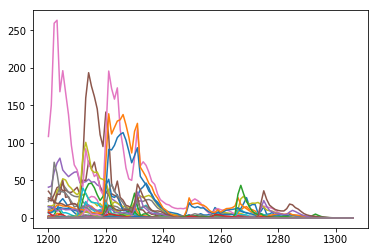

In [44]:
plot.plot(y_test)

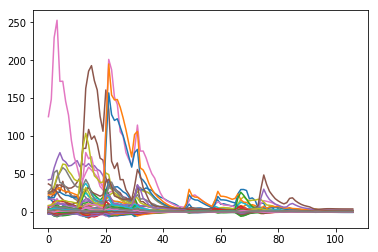

In [45]:
plot.plot(y_pred)

In [27]:
import sklearn
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print mfccs.mean(axis=1)
print mfccs.var(axis=1)

[-2.22044605e-16 -3.16915118e-16  4.18246346e-17 -1.13232547e-16
 -4.88804165e-17  4.36948419e-17 -1.39415449e-17 -9.34253525e-17
  1.27514130e-19 -7.32781200e-17  1.20373339e-16 -8.51794388e-17
  3.63840317e-17 -1.86340649e-16 -3.33236926e-17  5.33327848e-17
  8.56894953e-17 -8.90473674e-17  4.02519603e-17  2.12523550e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


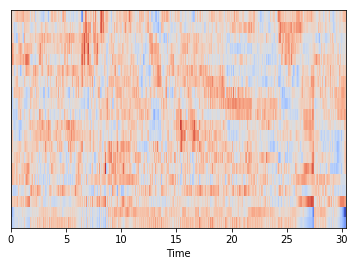

In [29]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [3]:
melSpectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
melSpectrogram


array([[4.56335491e-06, 4.37688079e-06, 2.82633082e-06, ...,
        4.88283371e-07, 6.22188415e-07, 4.02264859e-07],
       [6.95482171e-07, 2.56578891e-06, 1.41859269e-05, ...,
        2.76282021e-06, 3.30859618e-06, 4.87820526e-06],
       [7.29308041e-07, 1.86814272e-05, 1.05560317e-04, ...,
        7.54763759e-06, 1.46932419e-05, 1.07079318e-05],
       ...,
       [1.02299138e-09, 1.49326105e-09, 1.29336357e-09, ...,
        9.74003453e-10, 1.08191747e-09, 1.10202963e-09],
       [3.89398782e-10, 4.61464034e-10, 3.69564429e-10, ...,
        3.75400557e-10, 4.24808277e-10, 3.50127424e-10],
       [3.42807506e-11, 4.60646256e-11, 3.93423692e-11, ...,
        2.22742387e-11, 3.36579635e-11, 2.23889797e-11]])

In [4]:
logMel = librosa.amplitude_to_db(melSpectrogram)

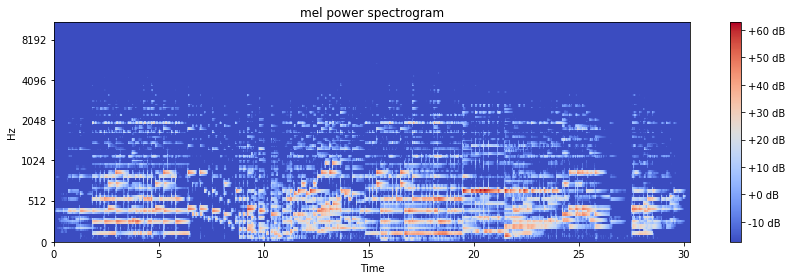

In [5]:
plot.figure(figsize=(12, 4))
librosa.display.specshow(logMel, sr=sr, x_axis='time', y_axis ='mel')
plot.title('mel power spectrogram')
plot.colorbar(format='%+2.0f dB')
plot.tight_layout()



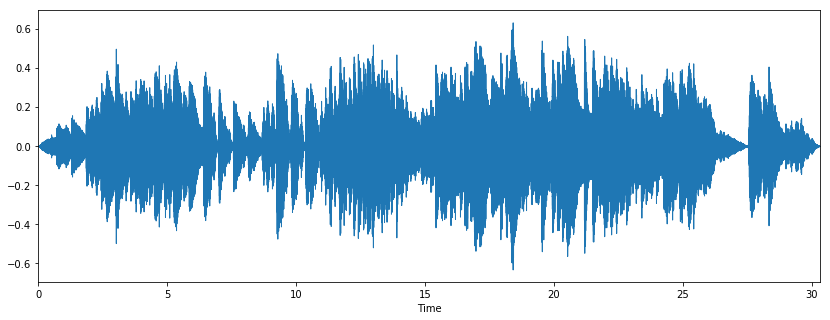

In [6]:
plot.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

In [7]:
ipd.Audio(filename)

In [8]:
#spectrogram without axis and white edges

pylab.axis('off')
pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
melSpectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(logMel, sr=sr)
pylab.savefig(spectrogramImage, bbox_inches=None, pad_inches=0)
pylab.close()


In [9]:
from scipy.ndimage.filters import convolve
from scipy.signal import convolve2d
from scipy import misc
import imageio

img = imageio.imread(spectrogramImage)

In [10]:
img.shape

(288, 432, 3)

Text(0.5,1,'Blue channel')

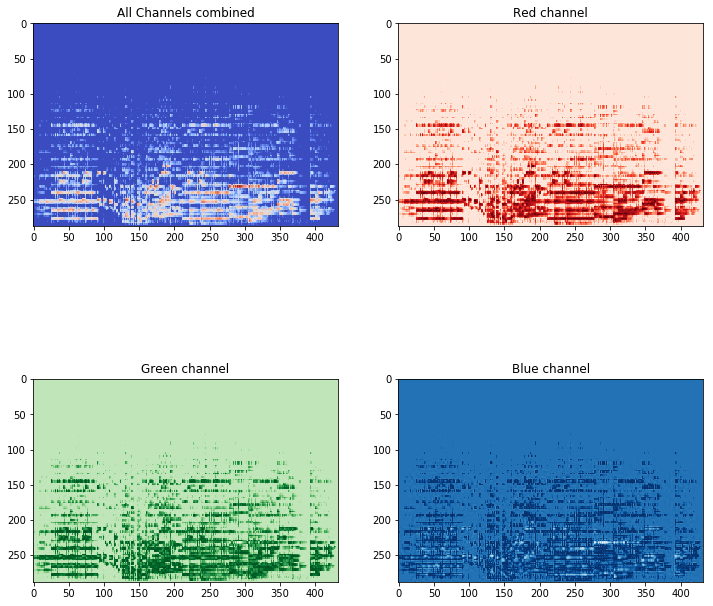

In [11]:
plot.figure(figsize=(12, 12))
plot.subplot(221)
plot.imshow(img)
plot.title("All Channels combined")

plot.subplot(222)
plot.imshow(img[:, : , 0], cmap='Reds')
plot.title("Red channel")

plot.subplot(223)
plot.imshow(img[:, : , 1], cmap='Greens')
plot.title("Green channel")

plot.subplot(224)
plot.imshow(img[:, : , 2], cmap='Blues')
plot.title("Blue channel")

In [12]:
img_tensor = img.reshape((1,288,432,3))

In [13]:
from keras.layers import Conv2D

In [14]:
model = Sequential()
model.add(Conv2D(1, (3, 3), strides=(2,1), input_shape=(288, 432, 3)))
model.compile('adam', 'mse')

In [16]:
imgPredictorTensor = model.predict(img_tensor)

In [18]:
imgPredictorTensor.shape

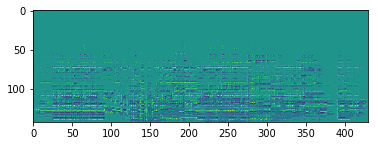

In [19]:
img_pred = imgPredictorTensor[0,:,:,0]
plot.imshow(img_pred)

In [20]:
weights = model.get_weights()

In [21]:
weights[0].shape

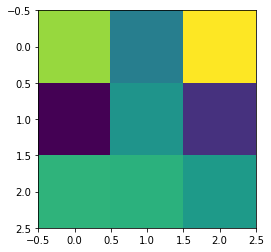

In [22]:
plot.imshow(weights[0][:,:,0,0])

In [23]:
import numpy as np
weights[0] = np.ones(weights[0].shape)

In [24]:
model.set_weights(weights)

In [25]:
imgPredictorTensor = model.predict(img_tensor)

In [26]:
img_pred = imgPredictorTensor[0, :, :, 0]

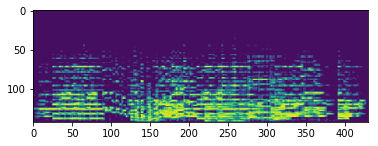

In [27]:
plot.imshow(img_pred)

In [28]:
model = Sequential()
model.add(Conv2D(1, (3, 3), input_shape=(288, 432, 3), padding='same'))
model.compile('adam', 'mse')

imgPredictorTensor = model.predict(img_tensor)

imgPredictorTensor.shape

(1, 288, 432, 1)